In [1]:
import rasterio
from osgeo import gdal
import geopandas as gpd
from pathlib import Path
import rasterio.mask
from shapely.geometry import box
from rasterio.plot import show

In [2]:
df_coh = gpd.read_file('coherence_tiles.geojson')
df_coh.head()

,bucket,key,url,tile_id,season,geometry
0,sentinel-1-global-coherence-earthbigdata,data/tiles/N00E005/N00E005_fall_vv_COH12.tif,https://sentinel-1-global-coherence-earthbigda...,N00E005,fall,"POLYGON ((6.00000 -1.00000, 6.00000 0.00000, 5..."
1,sentinel-1-global-coherence-earthbigdata,data/tiles/N00E005/N00E005_spring_vv_COH12.tif,https://sentinel-1-global-coherence-earthbigda...,N00E005,spring,"POLYGON ((6.00000 -1.00000, 6.00000 0.00000, 5..."
2,sentinel-1-global-coherence-earthbigdata,data/tiles/N00E005/N00E005_summer_vv_COH12.tif,https://sentinel-1-global-coherence-earthbigda...,N00E005,summer,"POLYGON ((6.00000 -1.00000, 6.00000 0.00000, 5..."
3,sentinel-1-global-coherence-earthbigdata,data/tiles/N00E005/N00E005_winter_vv_COH12.tif,https://sentinel-1-global-coherence-earthbigda...,N00E005,winter,"POLYGON ((6.00000 -1.00000, 6.00000 0.00000, 5..."
4,sentinel-1-global-coherence-earthbigdata,data/tiles/N00E006/N00E006_fall_vv_COH12.tif,https://sentinel-1-global-coherence-earthbigda...,N00E006,fall,"POLYGON ((7.00000 -1.00000, 7.00000 0.00000, 6..."


In [3]:
def crop_raster_from_bounds(image_path: Path | str, bounds: list[float]) -> tuple:
    """Bounds must be in lon/lat xmin, ymin, xmax, ymax (epsg:4326)"""
    geo = box(*bounds)
    print(bounds)
    with rasterio.open(image_path) as src:
        cropped_image, cropped_transform = rasterio.mask.mask(src, [geo], crop=True)
        p = src.profile

    p.update({"driver": "GTiff",
              "height": cropped_image.shape[1],
              "width": cropped_image.shape[2],
              "transform": cropped_transform,
              "compress": "lzw"})

    return cropped_image, p

def build_coh_vrt(extent: list, 
                  out_path: Path,
                  season='summer'):
    if season not in ['summer', 'fall', 'spring', 'winter']:
        raise ValueError('Season must be "summer", "spring", "fall", or "summer"')
    bbox = box(*extent)
     
    ind_inter = df_coh.geometry.intersects(bbox)
    ind_season = df_coh.season == season
    df_subset = df_coh[ind_inter & ind_season].reset_index(drop=True)
    gdal.BuildVRT(str(out_path), df_subset.url.tolist())
    return out_path

def get_coh_raster(extent: list[float], season='summer') -> tuple:
    tmp_vrt = Path('coh_data_tmp.vrt')
    build_coh_vrt(extent, tmp_vrt, season=season)
    X, p = crop_raster_from_bounds(tmp_vrt,
                                   extent)
    tmp_vrt.unlink()
    p['driver'] = 'GTiff'
    return X, p

In [4]:
# as xmin, ymin, xmax, ymax in epsg:4326
bounds = [-119., 33.402, -118., 34.435]

X, p = get_coh_raster(bounds, season='fall')

/Users/cmarshak/mambaforge/envs/s1_coherence/lib/python3.11/site-packages/osgeo/gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


[-119.0, 33.402, -118.0, 34.435]


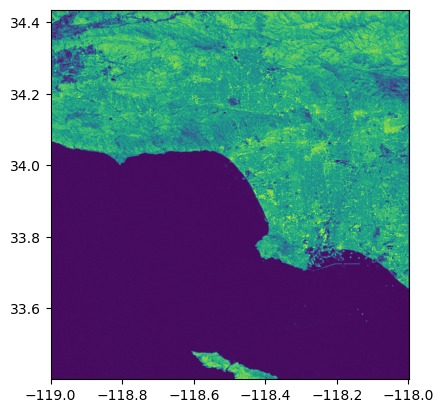

<Axes: >

In [5]:
show(X, transform=p['transform'])